# Fitting models in botorch with a torch.optim.Optimizer

botorch provides a convenient `botorch.fit.fit_gpytorch_model` function with sensible defaults that work on most basic models, including those that botorch ships with. However, in more advanced uses cases you may need or want to implement your own model fitting logic.

This tutorial allows you to customize model fitting to your needs using the familiar PyTorch-style model fitting loop.

This tutorial is adapted from GPyTorch's [Simple GP Regression Tutorial](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Simple_GP_Regression/Simple_GP_Regression.ipynb) and has very few changes because the out-of-the box models that botorch provides are GPyTorch models; in fact, they are proper subclasses that add simply add the `botorch.models.Model` API functions.

In [1]:
import math
import torch

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
dtype = torch.float
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Set up function to model
In this tutorial we will model a simple sinusoidal function with i.i.d. Gaussian noise:
$$y = \sin(2\pi x) + \epsilon, ~\epsilon \sim \mathcal N(0,0.1)$$

#### Initialize training data

In [3]:
# use regular spaced points on the interval [0, 1]
train_X = torch.linspace(0, 1, 15, dtype=dtype, device=device)
# sample observed values and add some synthetic noise
train_Y = torch.sin(train_X * (2 * math.pi)) + torch.randn_like(train_X) * 0.1

#### Initialize model
We will model the function using a `botorch.models.SingleTaskGP`, which by default uses a `gpytorch.likelihoods.GaussianLikelihood` and infers the unknown noise level. 

In [4]:
from botorch.models import SingleTaskGP

model = SingleTaskGP(train_X=train_X, train_Y=train_Y)

#### Define marginal log likelihood 
We will optimizing the the kernel hyperparameters and the likelihood's noise parameter jointly by minimizing the negative `gpytorch.mlls.ExactMarginalLogLikelihood` (our loss function).

In [5]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

### Define optimizer and specify parameters to optimize
We will use stochastic gradient descent (`torch.optim.SGD`) to optimize the kernel hyperparameters and the noise level. In this example, we will use a simple fixed learning rate of 0.1, but in practice the learning may need to adjusted. You can use any of 

Notes:
- As the `GaussianLikelihood` module is a of child (submodule) of the `SingleTaskGP` moduel, `model.parameters()` will also include the noise level of the `GaussianLikelihood`. 
- A subset of the parameters could be passed to the optimizer to tune those parameters, while leaving the other parameters fixed.

In [6]:
from torch.optim import SGD

optimizer = SGD([{'params': model.parameters()}], lr=0.1)

### Fit model hyperparameters and noise level
Now we are ready to write our optimization loop. We will perform 100 epochs of stochastic gradient descent using our entire training set.

In [7]:
NUM_EPOCHS = 100

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_X)
    # Compute negative marginal log likelihood
    loss = -mll(output, train_Y)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
            f"noise: {model.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()

Epoch  10/100 - Loss: 1.439 lengthscale: 0.635 noise: 0.584
Epoch  20/100 - Loss: 1.351 lengthscale: 0.573 noise: 0.476
Epoch  30/100 - Loss: 1.257 lengthscale: 0.513 noise: 0.383
Epoch  40/100 - Loss: 1.152 lengthscale: 0.454 noise: 0.301
Epoch  50/100 - Loss: 1.035 lengthscale: 0.401 noise: 0.231
Epoch  60/100 - Loss: 0.914 lengthscale: 0.361 noise: 0.173
Epoch  70/100 - Loss: 0.800 lengthscale: 0.337 noise: 0.127
Epoch  80/100 - Loss: 0.692 lengthscale: 0.325 noise: 0.094
Epoch  90/100 - Loss: 0.592 lengthscale: 0.321 noise: 0.069
Epoch 100/100 - Loss: 0.500 lengthscale: 0.322 noise: 0.052


### Compute posterior over test points and plot fit
We plot the posterior mean and the 2 standard deviations from the mean.

In [8]:
# set model and likelihood to eval mode
model.eval()
model.likelihood.eval();

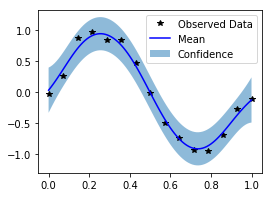

In [9]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 1, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Interfacing with Ax

It's simple to package up a custom optimizer loop like the one above and use it within Ax. As described in the [Using botorch with Ax tutorial](../custom_botorch_model_in_ax), this requires defining a custom `model_constructor` callable that then can ben passed to the `get_botorch` factory function.

In [10]:
def _get_and_fit_model(Xs, Ys, **kwargs):
    
    train_X, train_Y = Xs[0], Ys[0]
    model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model).to(train_X)
    model.train()
    
    optimizer = SGD([{'params': model.parameters()}], lr=kwargs.get("lr"))
    for epoch in range(kwargs.get("epochs")):
        optimizer.zero_grad()
        output = model(train_X)
        loss = -mll(output, train_Y)
        loss.backward()
        optimizer.step()
    
    return model